## Import relevant libraries

In [84]:
import ee, datetime    # Google Earth Engine
import pandas as pd
import numpy as np
import folium
import PIL 
from IPython.display import Image
from datetime import datetime as dt
from IPython.display import Image
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import geopandas as gpd
from sentinelsat.sentinel import read_geojson

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Autentication on Google Earth Engine

ee.Authenticate()
ee.Initialize()

Enter verification code: 4/1AX4XfWgsIP8oY6QOgN3cS4Gddtj491qcQSwwxVbylFI1pQe4QzGAJ40L29s

Successfully saved authorization token.


## Select Region

In [31]:
# Visualize the Area Of Interest (AOI) in the map: Zambezia in Mozambique 

# zambezia_map = folium.Map(location=[-16.653909049, 36.983681369], zoom_start=6) 
# zambezia_map

# Visualize the Area Of Interest (AOI) in the map: Niassa in Mozambique (Lago in Mozambique -12.6999972, 34.8166634)

# niassa_map = folium.Map(location=[-14.800088, 36.533772], zoom_start=6) 
# niassa_map

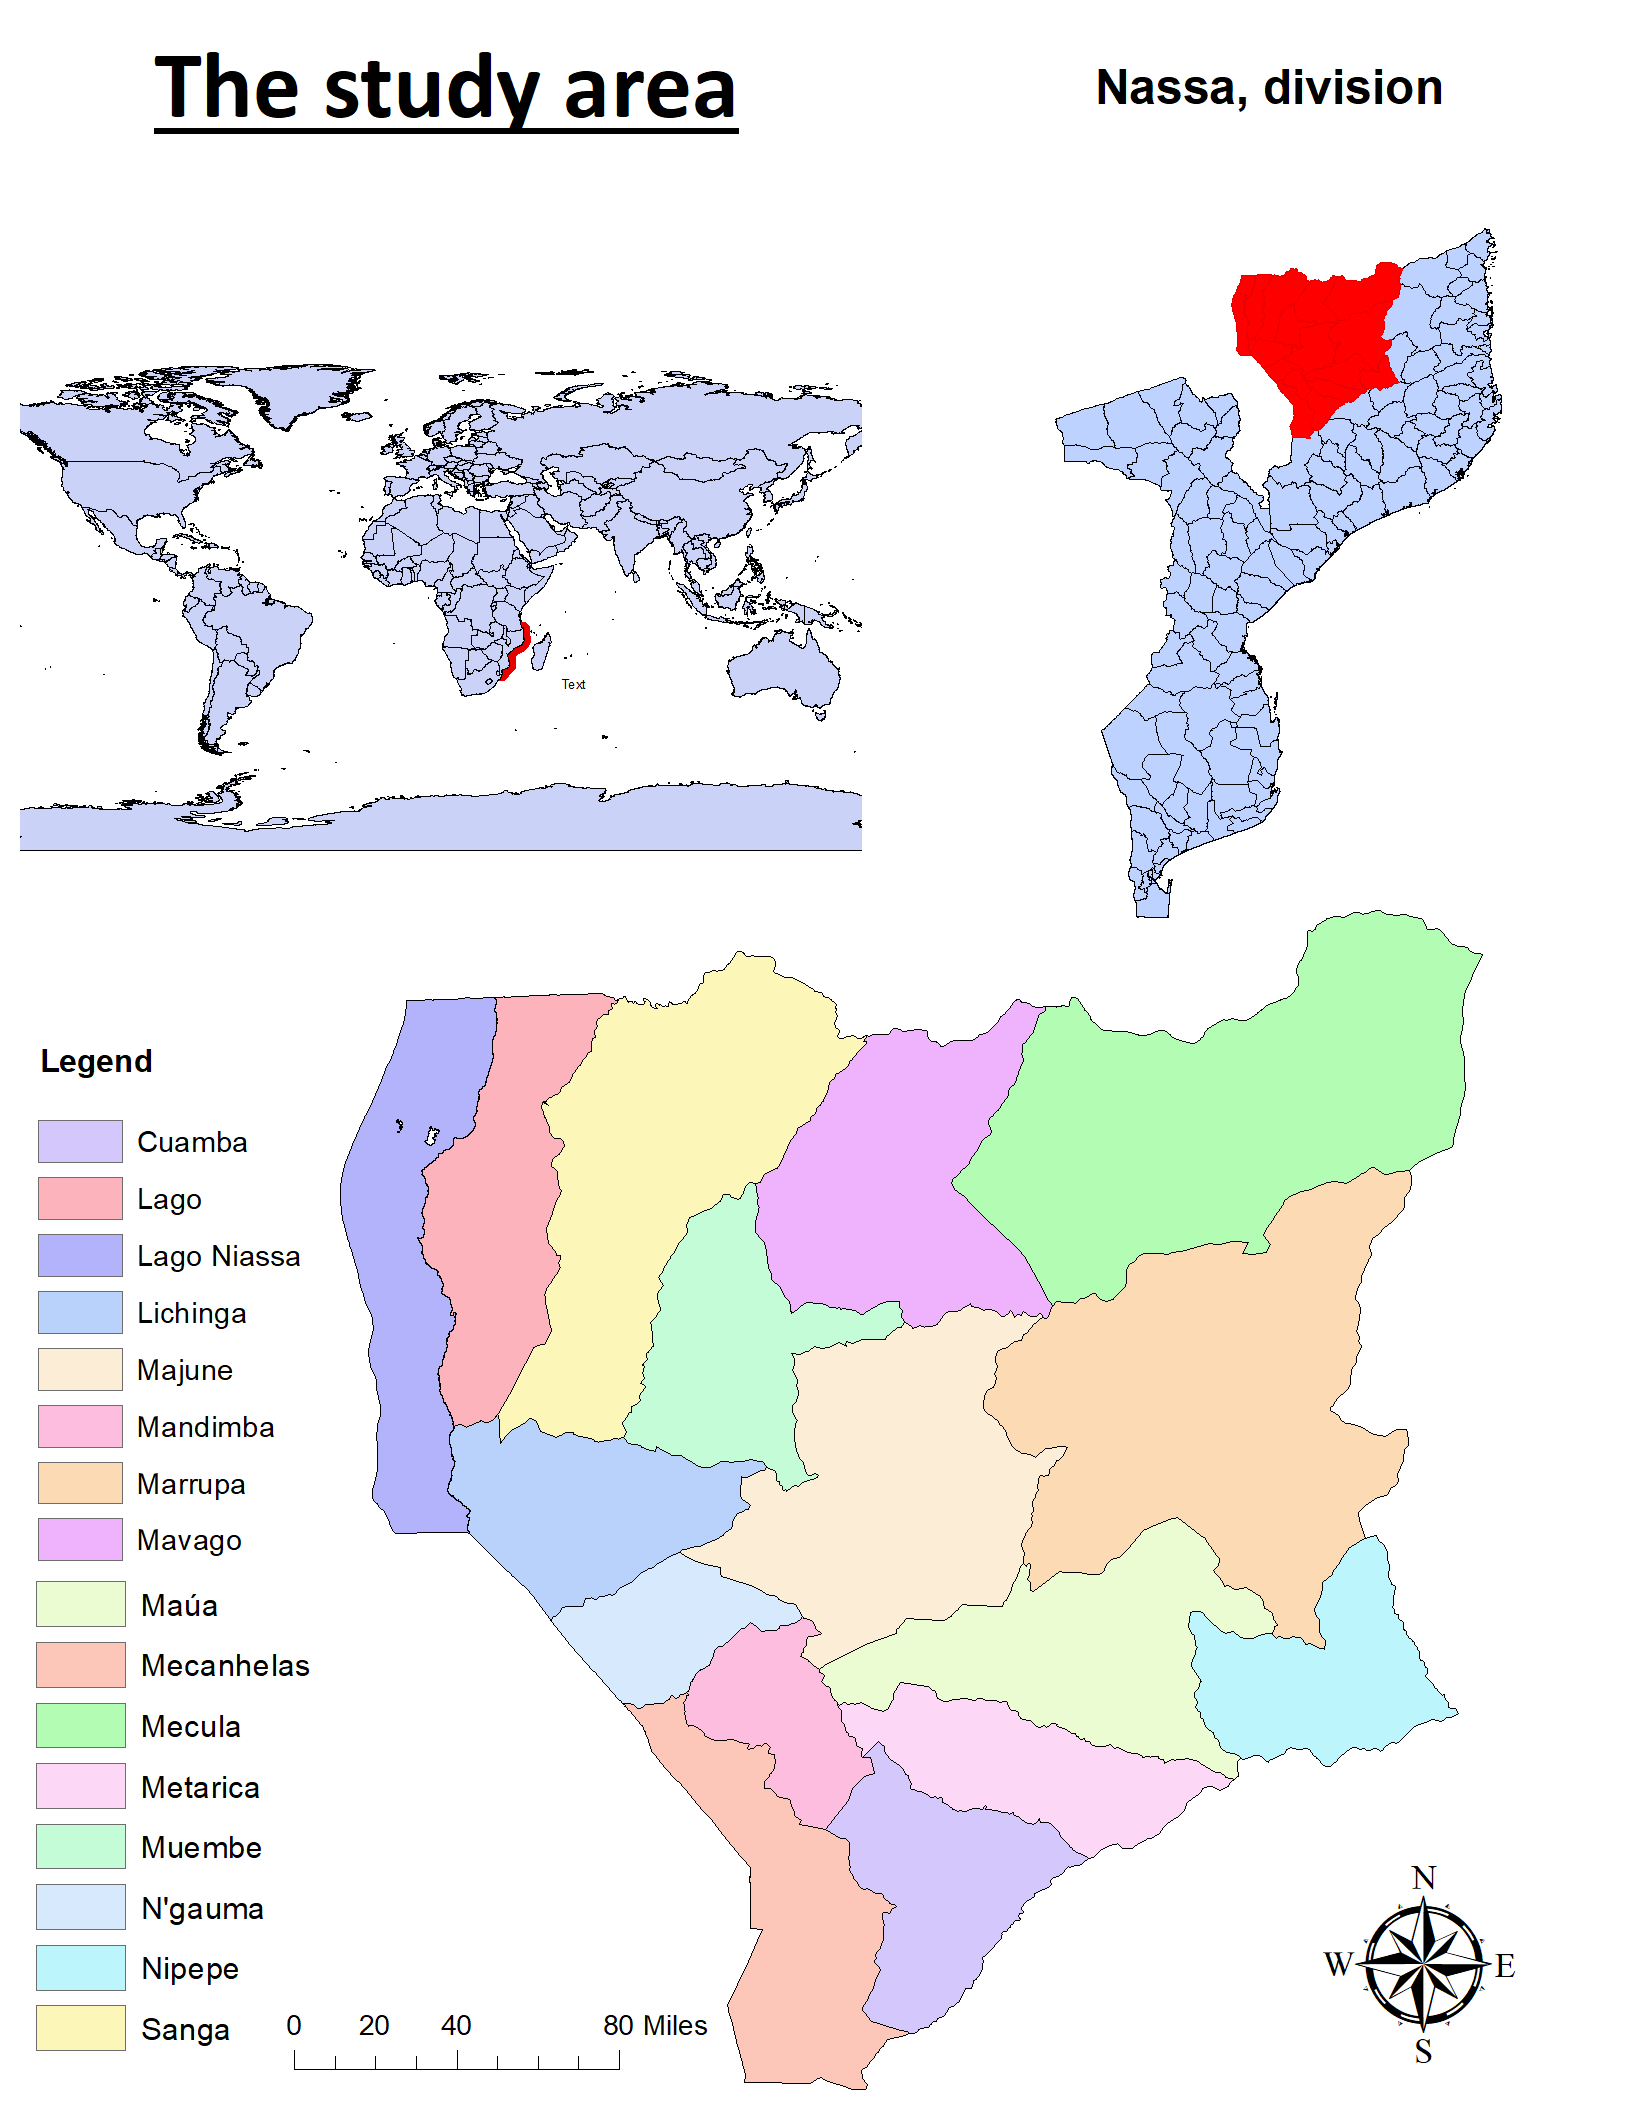

In [33]:
Image(filename='Nassa-png.png') 

## Landsat 8 Image Collection

Landsat 8 is operational since 2013. we will be taking every images till date with maximum allowable cloud cover of 20%

In [5]:
# # Our chosen Area of Interest is Niassa province in Mozambique

# geojson_file = {
#   "type": "FeatureCollection",
#   "features": [
#     {
#       "type": "Feature",
#       "properties": {},
#       "geometry": {
#         "type": "Polygon",
#         "coordinates": [
#           [
#             [
#               35.00244140625,
#               -11.5230875068685
#             ],
#             [
#               34.6728515625,
#               -12.211180191503997
#             ],
#             [
#               34.73876953125,
#               -13.368243250897287
#             ],
#             [
#               35.947265625,
#               -14.626108798876839
#             ],
#             [
#               35.88134765625,
#               -15.368949896534705
#             ],
#             [
#               36.25488281249999,
#               -15.32657180142083
#             ],
#             [
#               36.8701171875,
#               -14.689881366618762
#             ],
#             [
#               37.81494140625,
#               -14.221788628397585
#             ],
#             [
#               38.056640625,
#               -12.254127737657369
#             ],
#             [
#               38.408203125,
#               -11.415418041941416
#             ],
#             [
#               37.94677734374999,
#               -11.30770770776545
#             ],
#             [
#               37.68310546875,
#               -11.630715737981474
#             ],
#             [
#               35.00244140625,
#               -11.5230875068685
#             ]
#           ]
#         ]
#       }
#     }
#   ]
# }

In [26]:
geojson_file = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              34.71130371093749,
              -13.46976394051145
            ],
            [
              36.9580078125,
              -13.46976394051145
            ],
            [
              36.9580078125,
              -11.689893557325716
            ],
            [
              34.71130371093749,
              -11.689893557325716
            ],
            [
              34.71130371093749,
              -13.46976394051145
            ]
          ]
        ]
      }
    }
  ]
}

In [34]:
coords = geojson_file['features'][0]['geometry']['coordinates']

In [28]:
# coords = [
#     [[-12.9581997999999, 31.93349821], 
#      [-12.95815087, 31.9335215799999], 
#      [-12.95806292, 31.93357597], 
#      [-12.95796051, 31.93363965], 
#      [-12.95788025, 31.93371948], 
#      [-12.9578030099999, 31.93379418], 
#      [-12.95781106, 31.93390153], 
#      [-12.95789736, 31.9339897899999], 
#      [-12.95793489, 31.93408439], 
#      [-12.95786178, 31.9341551899999], 
#      [-12.95776931, 31.93422085], 
#      [-12.95766519, 31.93427272], 
#      [-12.9575497, 31.93428878], 
#      [-12.95751684, 31.9341802599999], 
#      [-12.95750443, 31.93405543], 
#      [-12.95748614, 31.9339395599999], 
#      [-12.9574570799999, 31.9338215499999]]
#          ]

In [29]:
# Landsat 8 surface reflectance imagery
# Take images up to 20% cloud coverage
# Take 2 years image data starting at 2019

landsat = ee.ImageCollection("LANDSAT/LC08/C01/T1_RT_TOA").filter(ee.Filter.lt('CLOUD_COVER', 20)).\
          filterDate('2019-09-01','2021-09-30')  




# setting the Area of Interest (AOI)
coords = geojson_file['features'][0]['geometry']['coordinates']
niassa_AOI =  ee.Geometry.Polygon(coords)

# filter area
landsat_AOI = landsat.filterBounds(niassa_AOI)

In [30]:
print('Total number of images in the collection is :', landsat_AOI.size().getInfo())

Total number of images in the collection is : 150


In [35]:
# Names of each Landsat 8 band

landsat_AOI.first().bandNames().getInfo()

['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'BQA']

For Landsat 8 dataset:

- B4, B3 and B2 are the Red, Green and Blue bands respectively
- B5 is the Near Infrared (NIR) band

In [37]:
# # Plot the 'first' image in the collection

# # List of images
# listOfImages = landsat_AOI.toList(landsat_AOI.size())

# # Plot in RGB color composite
# palette = ['red', 'green', 'blue']
# parameters = {'min': 0,
#               'max': 1000,
#               'dimensions': 512,
#               'bands': ['B4', 'B3', 'B2'],
#               'region': niassa_AOI} 
             
# niassa_map.addLayer(ee.Image(listOfImages.get(1)), parameters)
# niassa_map

##  NDVI Analysis

NDVI of every image pixels in the images will be calculated by the equation:
\begin{equation}
\mbox{NDVI} = \frac{\mbox{NIR} - \mbox{Red}}{\mbox{NIR} + \mbox{Red}}
\end{equation}

Where, NIR is B5 band and Red is B4 band.
Average NDVI will be calculated on every images to get time-series NDVI of the AOI.

### NDVI Calculation

In [41]:
# Function to calculate 'NDVI' and add a additional band to every images in the collection

def addNDVI(image):
    ndvi = image.normalizedDifference(['B5', 'B4']).rename('NDVI')
    return image.addBands(ndvi)

with_ndvi = landsat_AOI.map(addNDVI)

In [42]:
# Function to calculate 'average NDVI' on every images in the collection

def meanNDVI(image):
    image = ee.Image(image)
    meanDict = image.reduceRegion(reducer = ee.Reducer.mean().setOutputs(['NDVI']),
        geometry = niassa_AOI,
        scale = image.projection().nominalScale().getInfo(),
                                    maxPixels = 100000,
                                    bestEffort = True
                                  )
    
    return meanDict.get('NDVI').getInfo()

In [43]:
# Calculate 'average NDVI' for every images

listOfImages_ndvi = with_ndvi.select('NDVI').toList(with_ndvi.size())

ndvi_collection = []

for i in range(listOfImages_ndvi.length().getInfo()):
    image = ee.Image(listOfImages_ndvi.get(i-1))
    temp_ndvi = meanNDVI(image)
    ndvi_collection.append(temp_ndvi)

In [44]:
# Extract 'dates' from the image collection

dates = np.array(with_ndvi.aggregate_array("system:time_start").getInfo())
day = [datetime.datetime.fromtimestamp(i/1000).strftime('%Y-%m-%d') for i in (dates)]

## Time-series NDVI Dataframe

In [47]:
# Make a dataframe with 'day' and 'NDVI' columns

ndvi_df = pd.DataFrame(ndvi_collection, index = day, columns = ['ndvi'])
ndvi_df.index = pd.to_datetime(ndvi_df.index, format="%Y/%m/%d")
ndvi_df.sort_index(ascending = True, inplace = True)

ndvi_df.head(3)

,ndvi
2019-09-06,0.406931
2019-09-06,0.359706
2019-09-06,0.344545


## Get Daily NDVI Data

We want NDVI which requires the data to have regular interval such as daily, weekly and such. Filtering the data by cloud cover percentage yields irregular interval NDVI data. In this section, we will up-sample to get daily NDVI data with linear interpolation.

In [48]:
# Up-sampple the date column

ndvi_df_daily = ndvi_df.resample('D').median()

# Linear interpolate NDVI data

ndvi_df_daily.interpolate(method='polynomial', order = 1, inplace = True)
ndvi_df_daily.head(3)

,ndvi
2019-09-06,0.359706
2019-09-07,0.347730
2019-09-08,0.335753


In [64]:
ndvi_df_daily.isnull().sum()

ndvi    0
dtype: int64

## Plot NDVI Data

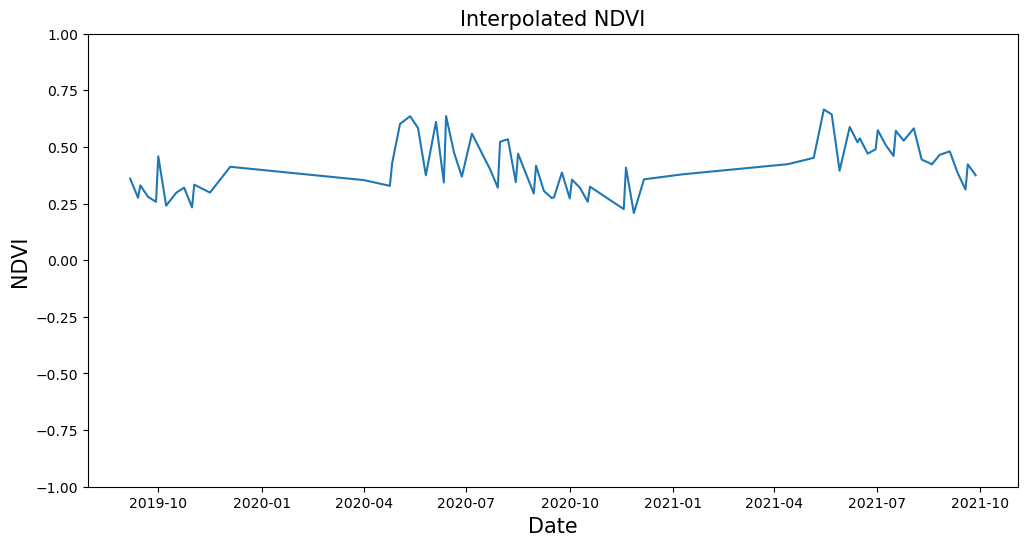

In [86]:
plt.figure(figsize=(12,6), dpi=100)
plt.plot(ndvi_df_daily)
plt.xlabel('Date', fontsize=15)
plt.ylabel('NDVI', fontsize=15)
plt.title("Interpolated NDVI", fontsize=15)
plt.ylim([-1, 1])
plt.savefig('NDVI_Plot.png')
plt.show()

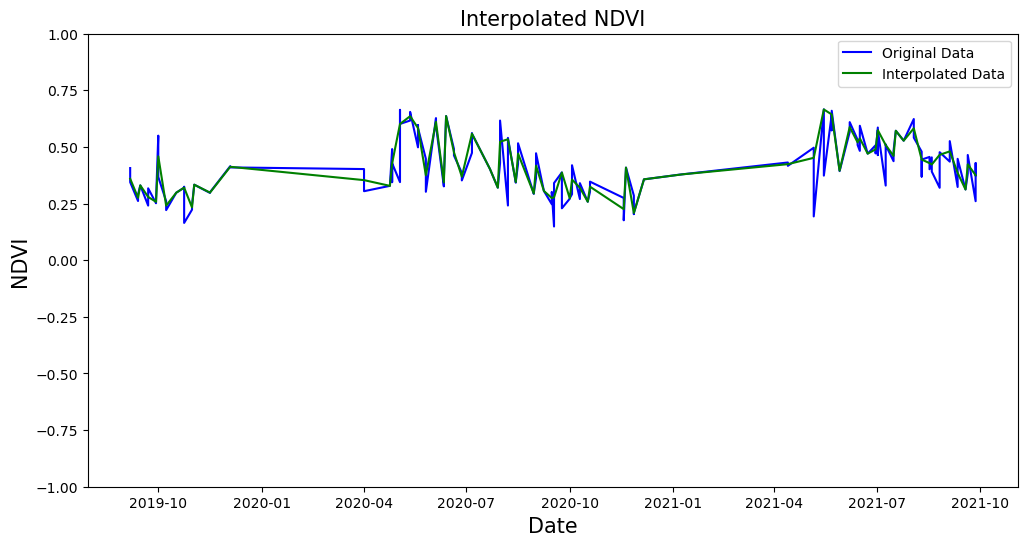

In [87]:
plt.figure(figsize=(12,6), dpi=100)
plt.plot(ndvi_df, 'b')
plt.plot(ndvi_df_daily, 'g')
plt.xlabel('Date', fontsize=15)
plt.ylabel('NDVI', fontsize=15)
plt.legend(['Original Data', 'Interpolated Data'])
plt.title("Interpolated NDVI", fontsize=15)
plt.ylim([-1, 1])
plt.savefig('NDVI_data_Plot.png')
plt.show()

## Trend and Seasonality 

- **Trend:** It show a long-term behavior and tendency over a period of time. e.g. if the NDVI is increasing/decreasing over a year.
- **Seasonality:** It show a periodic variation in the NDVI that we see every year. It tells which part of the year NDVI increases/decreases and that happens in cyclic manner over the years.

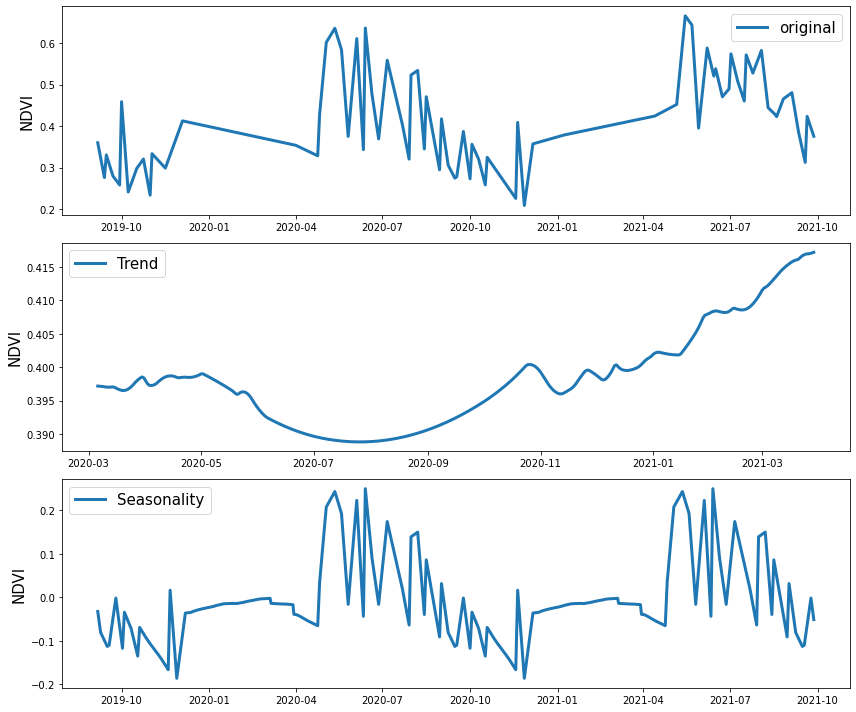

In [88]:
# Application of decompomposition on NDVI 

# additive worked better in terms of seasonality decomposition compared to multiplicative
decomposition = seasonal_decompose(ndvi_df_daily, model= 'additive', period = 365)    

# assign trend, seasonal components from decomposed data 
trend = decomposition.trend
seasonal = decomposition.seasonal


# Plot the trend and the seasonality
plt.figure(figsize=(12,10))

plt.title('Time-series NDVI', fontsize=15)
plt.xlabel('Date', fontsize=15)

plt.subplot(311)
plt.plot(ndvi_df_daily, label = 'original', linewidth=3)
plt.ylabel('NDVI', fontsize=15)
plt.legend(loc = 'best', fontsize=15)

plt.subplot(312)
plt.plot(trend, label = 'Trend', linewidth=3)
plt.ylabel('NDVI', fontsize=15)
plt.legend(loc = 'best', fontsize=15)

plt.subplot(313)
plt.plot(seasonal, label = 'Seasonality', linewidth=3)
plt.ylabel('NDVI', fontsize=15)
plt.legend(loc = 'best', fontsize=15)

plt.savefig('Trend_Seasonality_Plot.png')

plt.tight_layout()

We can see that:

- The NDVI has decreasing trend from May until August. From August till today it shows increasing trend. 
- Seasonality is constant over time but follows strictly cyclic manner. That is every year there are specific times when NDVI rises and falls.
- Seasonality shows that NDVI is lowest from May to December, whereas it is highest from April to May.

## Autocorrelation

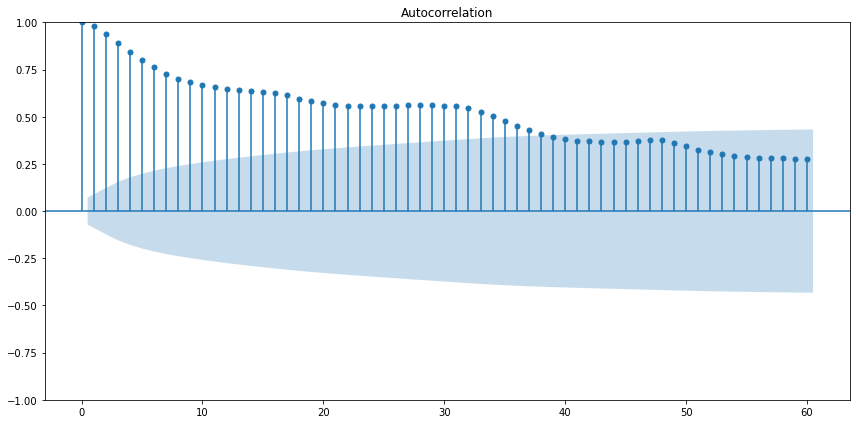

In [89]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

plot_acf(ndvi_df_daily, ax=ax, lags=60)
plt.savefig('Autocorrelation_Plot.png')
fig.tight_layout()

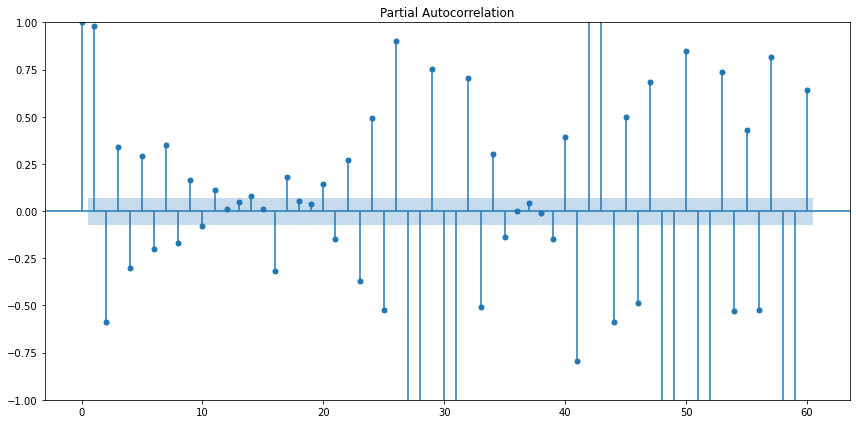

In [90]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

plot_pacf(ndvi_df_daily, ax=ax, lags=60)
plt.savefig('Partial_Autocorrelation_Plot.png')
fig.tight_layout()